In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Set seeds to make the experiment more reproducible.
import random
def seed_everything(seed = 0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed = 0
seed_everything(seed)

In [3]:
# Define some parameters for the data loader:
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
# Path of the dataset
input_path = '../input/paddy-disease-classification/'
train_data_dir = input_path + 'train_images/'
test_data_dir = input_path + 'test_images/'

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset="training",
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.


2022-10-10 23:59:14.642130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 23:59:14.750055: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 23:59:14.750842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 23:59:14.755073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    validation_split = 0.2,
    subset="validation",
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE)

Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [7]:
# We can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
n_classes = len(class_names)
print(class_names)

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro']


Show the first nine images and labels from the training set:

2022-10-10 23:59:18.675625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


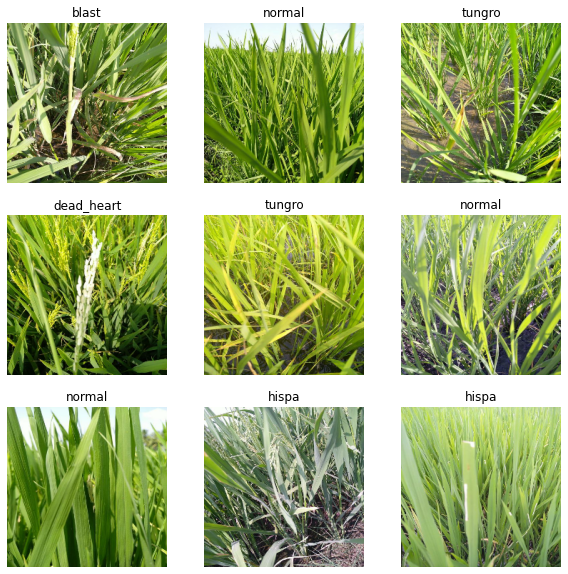

In [8]:
plt.figure(figsize = (10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
data_augmentation = keras.Sequential([
    layers.RandomRotation(factor = 0.1),
    layers.RandomFlip('horizontal'),
    layers.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
    layers.RandomContrast(factor = 0.1),
])

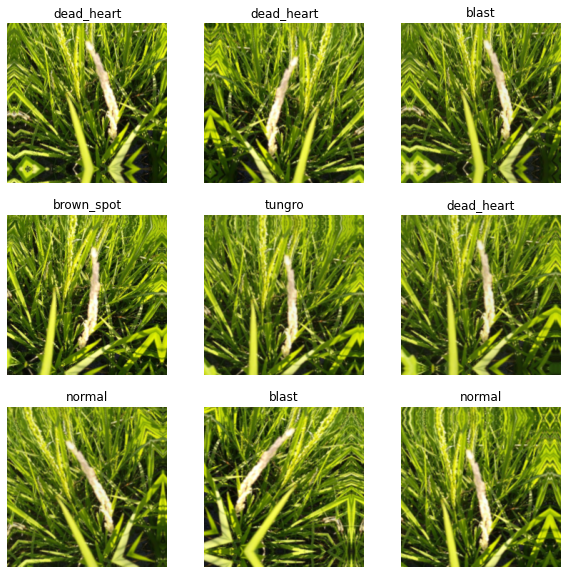

In [10]:
for image, labels in train_ds.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [11]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare_dataset(ds):
    def input_preprocess(image, label):
        label = tf.one_hot(label, n_classes)
        return image, label
    ds = ds.map(input_preprocess, num_parallel_calls = AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size = AUTOTUNE)
    return ds

In [12]:
train_ds = prepare_dataset(train_ds)
val_ds = prepare_dataset(val_ds)

In [13]:
def create_model(n_classes, fine_tune = 0):
    inputs = layers.Input(shape = (IMG_SIZE, IMG_SIZE, 3))
    x = layers.Rescaling(1.0/255)(inputs)
    x = data_augmentation(x)
    conv_base = tf.keras.applications.VGG16(include_top = False, input_tensor = x, weights = 'imagenet')

    # Freeze the pretrained weights
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name = 'gap')(conv_base.output)
    x = layers.BatchNormalization()(x)
    
    initializer = tf.keras.initializers.GlorotUniform()
    x = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.l2(0.001), kernel_initializer = initializer, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = layers.Dense(n_classes, kernel_initializer = initializer, activation = 'softmax', name = 'pred')(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name = 'VGG16')
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3), 
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy'])
    
    return model

model = create_model(n_classes, 2)

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856 

In [15]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5',
                                  save_best_only = True,
                                  verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 10,
                           restore_best_weights = True,
                           mode = 'min')

rlrop = ReduceLROnPlateau(monitor = 'val_loss', 
                          factor = 0.5, 
                          patience = 3, 
                          verbose = 1)

In [17]:
%%time
epochs = 50
history = model.fit(train_ds,
                    epochs = epochs,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rlrop] )

Epoch 1/50
261/261 [==============================] - 22s 85ms/step - loss: 1.3670 - accuracy: 0.6101 - val_loss: 1.6847 - val_accuracy: 0.5195
Epoch 2/50
261/261 [==============================] - 22s 84ms/step - loss: 1.1376 - accuracy: 0.6846 - val_loss: 1.1355 - val_accuracy: 0.6886
Epoch 3/50
261/261 [==============================] - 22s 85ms/step - loss: 0.9907 - accuracy: 0.7240 - val_loss: 1.5584 - val_accuracy: 0.5829
Epoch 4/50
261/261 [==============================] - 22s 84ms/step - loss: 0.8827 - accuracy: 0.7616 - val_loss: 1.0571 - val_accuracy: 0.7251
Epoch 5/50
261/261 [==============================] - 22s 85ms/step - loss: 0.8075 - accuracy: 0.7856 - val_loss: 1.2401 - val_accuracy: 0.6732
Epoch 6/50
261/261 [==============================] - 22s 85ms/step - loss: 0.7523 - accuracy: 0.8031 - val_loss: 1.0112 - val_accuracy: 0.7487
Epoch 7/50
261/261 [==============================] - 22s 85ms/step - loss: 0.6762 - accuracy: 0.8250 - val_loss: 0.9089 - val_accuracy:

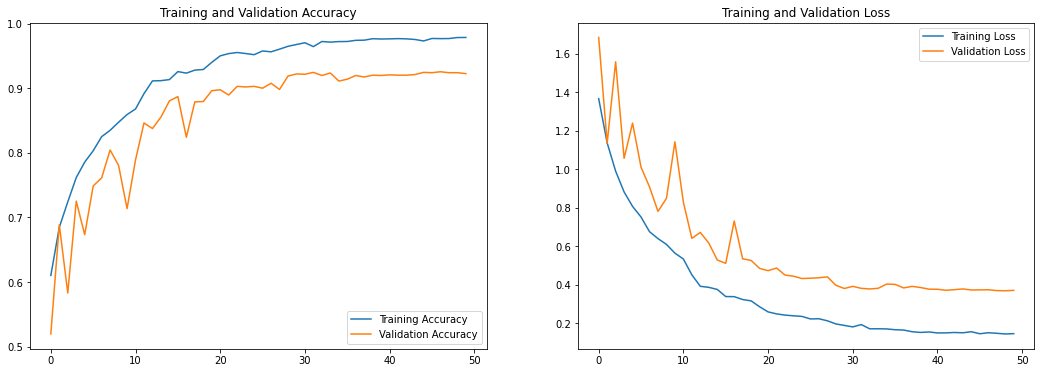

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig("VGG16.png")
plt.show()

In [19]:
def unfreeze_model(model):
    # Fine-tune from this layer while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = 'categorical_crossentropy', 
        metrics = ['accuracy'])

unfreeze_model(model)

In [22]:
%%time
fine_tune_epochs = 20
initial_epochs=50
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(train_ds,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = val_ds,
                         verbose = 1,callbacks = [tl_checkpoint_1, early_stop, rlrop])

Epoch 50/70
261/261 [==============================] - 49s 180ms/step - loss: 0.2033 - accuracy: 0.9571 - val_loss: 0.6460 - val_accuracy: 0.8405
Epoch 51/70
261/261 [==============================] - 46s 178ms/step - loss: 0.1880 - accuracy: 0.9618 - val_loss: 0.3871 - val_accuracy: 0.9154
Epoch 52/70
261/261 [==============================] - 47s 178ms/step - loss: 0.1748 - accuracy: 0.9648 - val_loss: 0.4189 - val_accuracy: 0.9097
Epoch 53/70
261/261 [==============================] - 47s 179ms/step - loss: 0.1720 - accuracy: 0.9681 - val_loss: 0.3942 - val_accuracy: 0.9164
Epoch 54/70
261/261 [==============================] - 47s 178ms/step - loss: 0.1688 - accuracy: 0.9677 - val_loss: 0.3244 - val_accuracy: 0.9289
Epoch 55/70
261/261 [==============================] - 47s 179ms/step - loss: 0.1587 - accuracy: 0.9726 - val_loss: 0.4430 - val_accuracy: 0.9068
Epoch 56/70
261/261 [==============================] - 47s 179ms/step - loss: 0.1493 - accuracy: 0.9763 - val_loss: 0.3709 -

In [23]:
model.save("VGG16")
model.save("VGG16.h5")

2022-10-11 00:49:41.768825: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


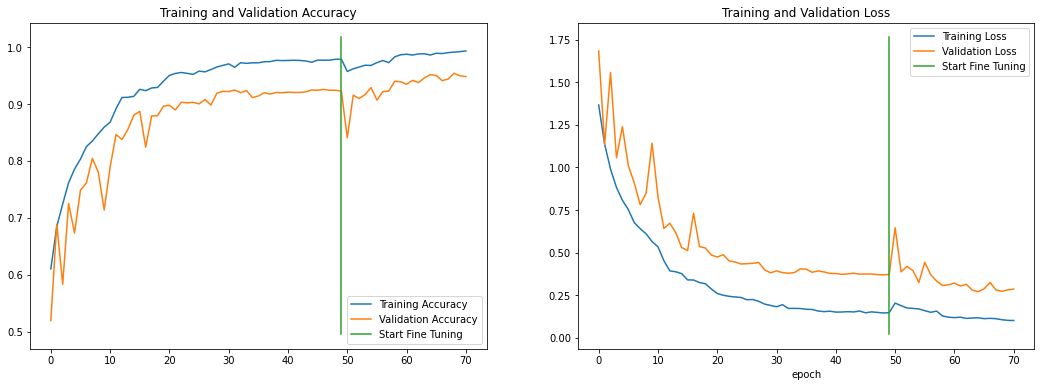

In [24]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = 'Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs - 1, initial_epochs - 1],
          plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs - 1, initial_epochs - 1],
         plt.ylim(), label = 'Start Fine Tuning')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("VGG16_FineTune.png")
plt.show()

In [ ]:
model.load_weights('./vgg16_best_weights.hdf5') # initialize the best trained weights

In [25]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    label_mode = None,
    seed = 123,
    image_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = False)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 3469 files belonging to 1 classes.


In [26]:
y_pred =  model.predict(test_ds, batch_size = 32, verbose = 1)
y_pred.shape

109/109 [==============================] - 16s 147ms/step


(3469, 10)

In [27]:
y_pred_classes = y_pred.argmax(axis = 1)
y_pred_classes.shape

(3469,)

In [28]:
y_classes_names = [class_names[x] for x in y_pred_classes]

In [29]:
predictions = pd.read_csv('/kaggle/input/paddy-disease-classification/sample_submission.csv')
predictions['label'] = y_classes_names
predictions.to_csv('vgg16_submission.csv', index = False)